<a href="https://colab.research.google.com/github/IT24102008/PG151MLProject/blob/IT24102070/IT24102070.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Code

In [ ]:

import pandas as pd

df = pd.read_csv('/content/preprocessed_stroke_data.csv')
display(df.head())

from sklearn.model_selection import train_test_split

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train.head())
display(y_train.head())

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6,7,8,9,stroke
0,2.305606,1.264816,0.250546,-0.430617,0.834524,0.333307,0.320894,-0.643058,-0.062396,-0.212238,1
1,1.453986,1.647613,-0.484745,0.160239,-1.163737,-0.412336,-0.231320,0.114952,0.208955,-0.247852,1
2,1.571330,-0.416363,-0.638432,0.597845,0.169697,-0.612380,0.748779,0.043821,-0.296528,-0.280570,1
3,1.537974,1.474840,0.641771,0.057266,0.514872,0.671681,-0.587822,0.692612,0.170372,-0.125929,1
4,1.642192,1.709071,-1.520156,0.258872,-1.103096,-0.424797,-0.188216,0.153761,-0.201548,0.639121,1


,0,1,2,3,4,5,6,7,8,9
802,1.264351,0.006483,-1.252349,-1.026351,-0.083969,-0.743146,0.144142,-0.470554,0.004641,-0.268659
3927,1.068100,-0.938814,0.224517,0.082382,0.289926,0.575841,-0.330341,-0.018948,-0.017597,-0.167047
2337,-0.859845,-1.143621,1.207896,0.744460,-0.350514,-0.374114,-0.127870,-0.143663,-0.375655,-0.063124
3910,-0.587292,-0.900560,0.263361,-1.005875,0.219439,0.244372,0.378785,-0.603102,0.586813,0.121337
1886,-1.693269,-0.606747,-0.481046,1.015554,-0.161294,-0.348477,-0.122587,-0.117882,-0.422131,-0.065420


,stroke
802,0
3927,0
2337,0
3910,0
1886,0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022


Confusion Matrix:
[[960   0]
 [ 62   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1st refined code

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV


data = pd.read_csv('/content/preprocessed_stroke_data.csv')


X = data.drop('stroke', axis=1)
y = data['stroke']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_scaled, y)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=10)
X_selected = rfe.fit_transform(X_resampled, y_resampled)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)


param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(logreg, param_grid, scoring=make_scorer(f1_score), cv=cv, n_jobs=-1)
grid_search.fit(X_selected, y_resampled)


calibrated_clf = CalibratedClassifierCV(grid_search.best_estimator_, cv='prefit')
calibrated_clf.fit(X_selected, y_resampled)



y_pred = calibrated_clf.predict(X_selected)
print('Best Logistic Regression C:', grid_search.best_params_['C'])
print('Classification Report on Resampled Training Data:')
print(classification_report(y_resampled, y_pred, zero_division=0))
print('ROC AUC Score:', roc_auc_score(y_resampled, calibrated_clf.predict_proba(X_selected)[:,1]))

Best Logistic Regression C: 0.01
Classification Report on Resampled Training Data:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3951
           1       0.85      0.89      0.87      4545

    accuracy                           0.86      8496
   macro avg       0.86      0.85      0.85      8496
weighted avg       0.86      0.86      0.86      8496

ROC AUC Score: 0.9161018405054883


2nd refined code

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Best Logistic Regression C: 0.01
Classification Report on Resampled Training Data:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3951
           1       0.85      0.89      0.87      4545

    accuracy                           0.86      8496
   macro avg       0.86      0.85      0.85      8496
weighted avg       0.86      0.86      0.86      8496

ROC AUC Score: 0.9161018405054883


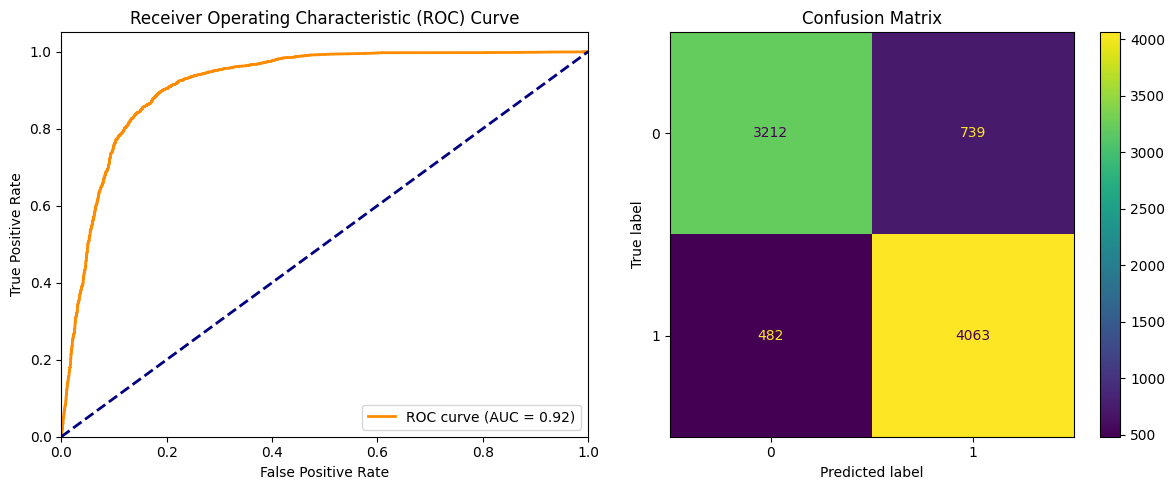

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt


data = pd.read_csv('/content/preprocessed_stroke_data.csv')


X = data.drop('stroke', axis=1)
y = data['stroke']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_scaled, y)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=10)
X_selected = rfe.fit_transform(X_resampled, y_resampled)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)


param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(logreg, param_grid, scoring=make_scorer(f1_score), cv=cv, n_jobs=-1)
grid_search.fit(X_selected, y_resampled)


calibrated_clf = CalibratedClassifierCV(grid_search.best_estimator_, cv='prefit')
calibrated_clf.fit(X_selected, y_resampled)

y_pred = calibrated_clf.predict(X_selected)
y_probs = calibrated_clf.predict_proba(X_selected)[:, 1]


print('Best Logistic Regression C:', grid_search.best_params_['C'])
print('Classification Report on Resampled Training Data:')
print(classification_report(y_resampled, y_pred, zero_division=0))
print('ROC AUC Score:', roc_auc_score(y_resampled, y_probs))


fpr, tpr, thresholds = roc_curve(y_resampled, y_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')


cm = confusion_matrix(y_resampled, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=calibrated_clf.classes_)
plt.subplot(1, 2, 2)
disp.plot(ax=plt.gca())
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()